<a href="https://colab.research.google.com/github/LeaCarop/Salary_prediction/blob/main/SalaryPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Adult Census Income dataset**

### *Variables numéricas*

*   `age`: The age of the individual in years.
*   `fnlwgt`: The number of individuals the Census Organizations believes that set of observations represents.
*   `education_num`:  An enumeration of the categorical representation of education. The higher the number, the higher the education that individual achieved. For example, an `education_num` of `11` represents `Assoc_voc` (associate degree at a vocational school), an `education_num` of `13` represents `Bachelors`, and an `education_num` of `9` represents `HS-grad` (high school graduate).
*   `capital_gain`: Capital gain made by the individual, represented in US Dollars.
*   `capital_loss`: Capital loss mabe by the individual, represented in US Dollars.
*   `hours_per_week`: Hours worked per week.

### *Variables categóricas*

*   `workclass`: The individual's type of employer. Examples include: `Private`, `Self-emp-not-inc`, `Self-emp-inc`, `Federal-gov`, `Local-gov`, `State-gov`, `Without-pay`, and `Never-worked`.
*   `education`: The highest level of education achieved for that individual.
*   `marital_status`: Marital status of the individual. Examples include: `Married-civ-spouse`, `Divorced`, `Never-married`, `Separated`, `Widowed`, `Married-spouse-absent`, and `Married-AF-spouse`.
*   `occupation`: The occupation of the individual. Example include: `tech-support`, `Craft-repair`, `Other-service`, `Sales`, `Exec-managerial` and more.
*   `relationship`:  The relationship of each individual in a household. Examples include: `Wife`, `Own-child`, `Husband`, `Not-in-family`, `Other-relative`, and `Unmarried`.
*   `gender`:  Gender of the individual available only in binary choices: `Female` or `Male`.
*   `race`: `White`, `Asian-Pac-Islander`, `Amer-Indian-Eskimo`, `Black`, and `Other`. 
*   `native_country`: Country of origin of the individual. Examples include: `United-States`, `Cambodia`, `England`, `Puerto-Rico`, `Canada`, `Germany`, `Outlying-US(Guam-USVI-etc)`, `India`, `Japan`, and more.

**Cargar librerías**


In [ ]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from matplotlib import pyplot as plt
from matplotlib import rcParams
import seaborn as sns

pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

from google.colab import widgets

from IPython.core.display import display, HTML
import base64
!pip install facets-overview==1.0.0
from facets_overview.feature_statistics_generator import FeatureStatisticsGenerator

**Descargar dataset**

In [ ]:
COLUMNS = ["age", "workclass", "fnlwgt", "education", "education_num",
           "marital_status", "occupation", "relationship", "race", "gender",
           "capital_gain", "capital_loss", "hours_per_week", "native_country",
           "income_bracket"]

train_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_train.csv')
test_csv = tf.keras.utils.get_file('adult.data', 
  'https://download.mlcc.google.com/mledu-datasets/adult_census_test.csv')

train_df = pd.read_csv(train_csv, names=COLUMNS, sep=r'\s*,\s*', 
                       engine='python', na_values="?")
test_df = pd.read_csv(test_csv, names=COLUMNS, sep=r'\s*,\s*', skiprows=[0],
                      engine='python', na_values="?")

3989504/3974305 [==============================] - 0s 0us/step


**Visualizar los datos es Facets Overview**

Facets es una herramienta de visualización interactiva (con estadística descriptiva e histogramas) que puede ayudarnos a explorar nuestro conjunto de datos, oferece las mismas métricas de salida que describe(). Esta herramienta permite analizar rápidamente la distribución de valores de cada variable.

In [ ]:
fsg = FeatureStatisticsGenerator()
dataframes = [
    {'table': train_df, 'name': 'trainData'}]
censusProto = fsg.ProtoFromDataFrames(dataframes)
protostr = base64.b64encode(censusProto.SerializeToString()).decode("utf-8")


HTML_TEMPLATE = """<script src="https://cdnjs.cloudflare.com/ajax/libs/webcomponentsjs/1.3.3/webcomponents-lite.js"></script>
        <link rel="import" href="https://raw.githubusercontent.com/PAIR-code/facets/1.0.0/facets-dist/facets-jupyter.html">
        <facets-overview id="elem"></facets-overview>
        <script>
          document.querySelector("#elem").protoInput = "{protostr}";
        </script>"""
html = HTML_TEMPLATE.format(protostr=protostr)
display(HTML(html))

**Convertir Dataset en tensores**

In [ ]:
def pandas_to_numpy(data):

  data = data.dropna(how="any", axis=0)

  labels = np.array(data['income_bracket'] == ">50K")   # separar el dataset en dos Numpy arrays
  features = data.drop('income_bracket', axis=1)
  features = {name:np.array(value) for name, value in features.items()}
  
  return features, labels

**Crear columna de variables categóricas**

In [ ]:
occupation = tf.feature_column.categorical_column_with_hash_bucket(
    "occupation", hash_bucket_size=1000)
native_country = tf.feature_column.categorical_column_with_hash_bucket(
    "native_country", hash_bucket_size=1000)

gender = tf.feature_column.categorical_column_with_vocabulary_list(
    "gender", ["Female", "Male"])
race = tf.feature_column.categorical_column_with_vocabulary_list(
    "race", [
        "White", "Asian-Pac-Islander", "Amer-Indian-Eskimo", "Other", "Black"
    ])
education = tf.feature_column.categorical_column_with_vocabulary_list(
    "education", [
        "Bachelors", "HS-grad", "11th", "Masters", "9th",
        "Some-college", "Assoc-acdm", "Assoc-voc", "7th-8th",
        "Doctorate", "Prof-school", "5th-6th", "10th", "1st-4th",
        "Preschool", "12th"
    ])
marital_status = tf.feature_column.categorical_column_with_vocabulary_list(
    "marital_status", [
        "Married-civ-spouse", "Divorced", "Married-spouse-absent",
        "Never-married", "Separated", "Married-AF-spouse", "Widowed"
    ])
relationship = tf.feature_column.categorical_column_with_vocabulary_list(
    "relationship", [
        "Husband", "Not-in-family", "Wife", "Own-child", "Unmarried",
        "Other-relative"
    ])
workclass = tf.feature_column.categorical_column_with_vocabulary_list(
    "workclass", [
        "Self-emp-not-inc", "Private", "State-gov", "Federal-gov",
        "Local-gov", "?", "Self-emp-inc", "Without-pay", "Never-worked"
    ])

**Crear columna de variables numéricas**

In [ ]:
age = tf.feature_column.numeric_column("age")
fnlwgt = tf.feature_column.numeric_column("fnlwgt")
education_num = tf.feature_column.numeric_column("education_num")
capital_gain = tf.feature_column.numeric_column("capital_gain")
capital_loss = tf.feature_column.numeric_column("capital_loss")
hours_per_week = tf.feature_column.numeric_column("hours_per_week")

**Cambio de `age` a variable categórica**

In [ ]:
age_buckets = tf.feature_column.bucketized_column(
    age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])

**Definir modelo**

In [ ]:
variables = [native_country, education, occupation, workclass, 
             relationship, age_buckets]
subgroup_variables = [gender]
feature_columns = variables + subgroup_variables

**Entrenamiento**

In [ ]:
deep_columns = [
    tf.feature_column.indicator_column(workclass),
    tf.feature_column.indicator_column(education),
    tf.feature_column.indicator_column(age_buckets),
    tf.feature_column.indicator_column(relationship),
    tf.feature_column.embedding_column(native_country, dimension=8),
    tf.feature_column.embedding_column(occupation, dimension=8),
]

In [ ]:
#Parámetros
HIDDEN_UNITS_LAYER_01 = 128 #@param
HIDDEN_UNITS_LAYER_02 = 64 #@param
LEARNING_RATE = 0.1 #@param
L1_REGULARIZATION_STRENGTH = 0.001 #@param
L2_REGULARIZATION_STRENGTH = 0.001 #@param

RANDOM_SEED = 512
tf.random.set_seed(RANDOM_SEED)

# Lista de métricas
METRICS = [
  tf.keras.metrics.TruePositives(name='tp'),
  tf.keras.metrics.FalsePositives(name='fp'),
  tf.keras.metrics.TrueNegatives(name='tn'),
  tf.keras.metrics.FalseNegatives(name='fn'), 
  tf.keras.metrics.BinaryAccuracy(name='accuracy'),
  tf.keras.metrics.Precision(name='precision'),
  tf.keras.metrics.Recall(name='recall'),
  tf.keras.metrics.AUC(name='auc'),
]

regularizer = tf.keras.regularizers.l1_l2(
    l1=L1_REGULARIZATION_STRENGTH, l2=L2_REGULARIZATION_STRENGTH)

model = tf.keras.Sequential([
  layers.DenseFeatures(deep_columns),
  layers.Dense(
      HIDDEN_UNITS_LAYER_01, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      HIDDEN_UNITS_LAYER_02, activation='relu', kernel_regularizer=regularizer),
  layers.Dense(
      1, activation='sigmoid', kernel_regularizer=regularizer)
])

model.compile(optimizer=tf.keras.optimizers.Adagrad(LEARNING_RATE),  
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [ ]:
EPOCHS = 10 #@param
BATCH_SIZE = 500 #@param

features, labels = pandas_to_numpy(train_df)
model.fit(x=features, y=labels, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
61/61 [==============================] - 3s 6ms/step - loss: 1.8383 - tp: 1298.0000 - fp: 678.0000 - tn: 21976.0000 - fn: 6210.0000 - accuracy: 0.7716 - precision: 0.6569 - recall: 0.1729 - auc: 0.7895
Epoch 2/10
61/61 [==============================] - 0s 6ms/step - loss: 1.4138 - tp: 3721.0000 - fp: 1509.0000 - tn: 21145.0000 - fn: 3787.0000 - accuracy: 0.8244 - precision: 0.7115 - recall: 0.4956 - auc: 0.8669
Epoch 3/10
61/61 [==============================] - 0s 6ms/step - loss: 1.1150 - tp: 3978.0000 - fp: 1612.0000 - tn: 21042.0000 - fn: 3530.0000 - accuracy: 0.8295 - precision: 0.7116 - recall: 0.5298 - auc: 0.8756
Epoch 4/10
61/61 [==============================] - 0s 6ms/step - loss: 0.8828 - tp: 4004.0000 - fp: 1651.0000 - tn: 21003.0000 - fn: 3504.0000 - accuracy: 0.8291 - precision: 0.7080 - recall: 0.5333 - auc: 0.8772
Epoch 5/10
61/61 [==============================] - 0s 6ms/step - loss: 0.7070 - tp: 3954.0000 - fp: 1609.0000 - tn: 21045.0000 - fn: 3554.0000 -

Aparentemente, viendo los resultados no parece un mal modelo.

**Evaluar el modelo**

In [ ]:
features, labels = pandas_to_numpy(test_df)
model.evaluate(x=features, y=labels);

943/943 [==============================] - 5s 4ms/step - loss: 0.4250 - tp: 4294.0000 - fp: 1884.0000 - tn: 20769.0000 - fn: 3214.0000 - accuracy: 0.8310 - precision: 0.6950 - recall: 0.5719 - auc: 0.8815


Cambiando los parámetros establecidos se puede entrenar el modelo en busca de resultados mejores. Los que he obetido no son malos, pero sí mejrables. Los ingresos se han predicho con una precisión (accuracy) de un 83.10% y un AUC de 88.15% en test.

### **Evaluación de la Equidad utilizando una matriz de confusión.**

**Definir matriz de confusión**

In [ ]:
def plot_confusion_matrix(
    confusion_matrix, class_names, subgroup, figsize = (8,6)):
 
  df_cm = pd.DataFrame(
      confusion_matrix, index=class_names, columns=class_names, 
  )

  rcParams.update({
  'font.family':'sans-serif',
  'font.sans-serif':['Liberation Sans'],
  })
  
  sns.set_context("notebook", font_scale=1.25)

  fig = plt.figure(figsize=figsize)

  plt.title('Confusion Matrix for Performance Across ' + subgroup)

  strings = np.asarray([['True Positives', 'False Negatives'],
                        ['False Positives', 'True Negatives']])
  labels = (np.asarray(
      ["{0:g}\n{1}".format(value, string) for string, value in zip(
          strings.flatten(), confusion_matrix.flatten())])).reshape(2, 2)

  heatmap = sns.heatmap(df_cm, annot=labels, fmt="", 
      linewidths=2.0, cmap=sns.color_palette("GnBu_d"));
  heatmap.yaxis.set_ticklabels(
      heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  heatmap.xaxis.set_ticklabels(
      heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
  plt.ylabel('References')
  plt.xlabel('Predictions')
  return fig

**Visualizar la matriz de confusión binaria y calcular las métricas por subgrupo**

- *Hombre*

,ACCURACY,PRECISION,RECALL,AUC
Male,0.7916,0.6956,0.5974,0.8545


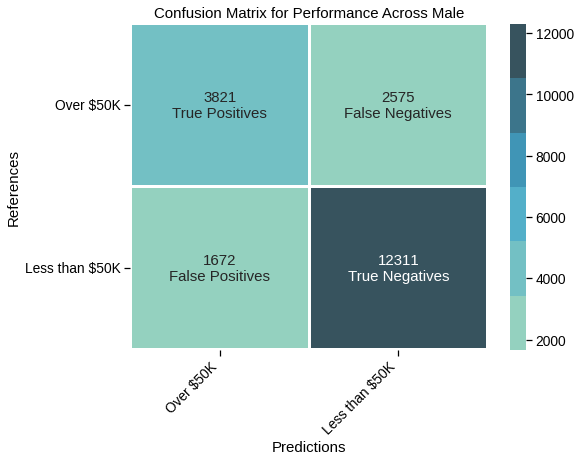

In [ ]:
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Male" #@param {type:"string"}

classes = ['Over $50K', 'Less than $50K']

subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

- *Mujer*

,ACCURACY,PRECISION,RECALL,AUC
Female,0.9130,0.6905,0.4254,0.9087


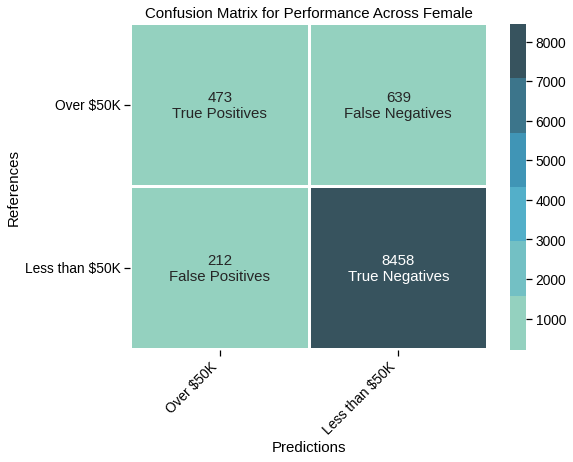

In [ ]:
CATEGORY  =  "gender" #@param {type:"string"}
SUBGROUP =  "Female" #@param {type:"string"}

classes = ['Over $50K', 'Less than $50K']

subgroup_filter  = test_df.loc[test_df[CATEGORY] == SUBGROUP]
features, labels = pandas_to_numpy(subgroup_filter)
subgroup_results = model.evaluate(x=features, y=labels, verbose=0)
confusion_matrix = np.array([[subgroup_results[1], subgroup_results[4]], 
                             [subgroup_results[2], subgroup_results[3]]])

subgroup_performance_metrics = {
    'ACCURACY': subgroup_results[5],
    'PRECISION': subgroup_results[6], 
    'RECALL': subgroup_results[7],
    'AUC': subgroup_results[8]
}
performance_df = pd.DataFrame(subgroup_performance_metrics, index=[SUBGROUP])
pd.options.display.float_format = '{:,.4f}'.format

plot_confusion_matrix(confusion_matrix, classes, SUBGROUP);
performance_df

### **CONCLUSIONES**

Con los parámetros predeterminados, es posible que el modelo funcione mejor para las mujeres que para los hombres. Específicamente, en nuestra ejecución, encontramos que tanto la precisión como el AUC para mujeres (0.9130 y 0.9087, respectivamente) superaron a los hombres (0.7916 y 0.8545, respectivamente). 

Observamos que el número de verdaderos positivos (True Positives) para las mujeres es mucho más bajo en comparación con los hombres (473 a 3821). Cuando analizamos las variables usando Facets Overview, vimos que había el doble de hombres que de mujeres (casi 2 a 1), lo que seguramente implica que, teniendo en cuenta que solo 7841 personas cobran > de $ 50.000, el número de mujeres que sobrepasen ese salario anual es relativamente bajo.

Todo esto sugiere que el modelo se está sobreajustando, en particular con respecto a las mujeres y al grupo de ingresos más bajos. En otras palabras, este modelo no se generalizará bien, particularmente con datos femeninos, ya que no tiene suficientes ejemplos positivos para que el modelo aprenda. Tampoco lo está haciendo mucho mejor con los hombres, ya que hay un número desproporcionadamente pequeño de grupos de altos ingresos en comparación con los de bajos ingresos, aunque no tan mal representados como con las mujeres.

Con suerte, al pasar por esta demostración de matriz de confusión, encontraremos que los resultados varían ligeramente de las métricas de rendimiento general, lo que resalta la importancia de evaluar el rendimiento del modelo en todos los subgrupos en lugar de en conjunto.
